## Detailed article explaination
The detailed code explanation for this article is available at the following link:

https://www.daniweb.com/programming/computer-science/tutorials/541255/track-faces-from-videos-with-margins-using-deep-learning-in-python

For my other articles for Daniweb.com, please see this link:

https://www.daniweb.com/members/1235222/usmanmalik57

## Installing and Importing Required Libraries

In [ ]:
! pip install deepface
! pip install moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.7 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=a75b1bac651d8ef1cdda674c99b1789a26d1b306aef43008aa1ef92dad14dce4
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
import cv2
from matplotlib import pyplot as plt
from deepface import DeepFace
import numpy as np
from moviepy.editor import *
import math

23-12-30 15:56:10 - Directory /root/.deepface created
23-12-30 15:56:10 - Directory /root/.deepface/weights created


## How Deepface Detect Images

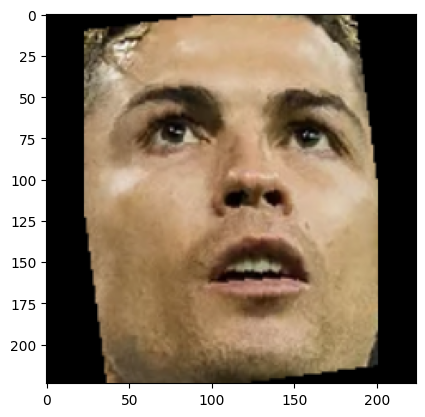

In [ ]:
image_path = r"/content/ronaldo.jpg"
image = cv2.imread(image_path)
face = DeepFace.extract_faces(img_path = image_path,
        target_size = (224, 224),
        detector_backend = "retinaface"
)

plt.imshow(face[0]['face'])

In [ ]:
print(face[0].keys())
print(face[0]['facial_area'])

dict_keys(['face', 'facial_area', 'confidence'])
{'x': 570, 'y': 130, 'w': 130, 'h': 163}


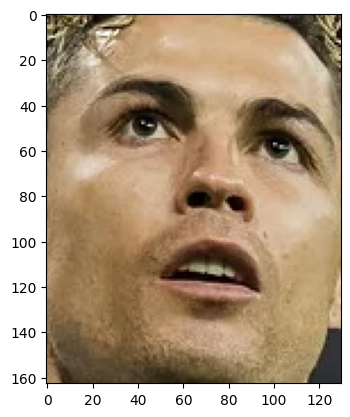

In [ ]:
# Calculate the new coordinates, ensuring they do not exceed the image bounds
x1 = face[0]['facial_area']['x']
y1 = face[0]['facial_area']['y']
x2 = face[0]['facial_area']['x'] + face[0]['facial_area']['w']
y2 = face[0]['facial_area']['y'] + face[0]['facial_area']['h']

# Extract the region of interest (ROI) with the additional margin
sub_img = image[y1:y2, x1:x2]

# Convert the image from BGR to RGB for displaying with matplotlib
sub_img = cv2.cvtColor(sub_img, cv2.COLOR_BGR2RGB)

plt.imshow(sub_img)

## Frame Size Normalization

In [ ]:
import copy

def size_normalization(faces):
    updated_faces = copy.deepcopy(faces)

    # Find the dimensions of the largest face
    max_w = max(f['facial_area']['w'] for f in updated_faces)
    max_h = max(f['facial_area']['h'] for f in updated_faces)

    # Update each facial_area dictionary
    for f in updated_faces:
        delta_w = max_w - f['facial_area']['w']
        delta_h = max_h - f['facial_area']['h']

        # Center the face within the new dimensions
        f['facial_area']['x'] -= delta_w // 2
        f['facial_area']['y'] -= delta_h // 2
        f['facial_area']['w'] = max_w
        f['facial_area']['h'] = max_h

    return updated_faces


## Adding Margins to Video Frames

In [ ]:
def crop_image_area(img, facial_area, margin):


    # Calculate the new coordinates, ensuring they do not exceed the image bounds
    x1 = max(facial_area['x'] - margin, 0)
    y1 = max(facial_area['y'] - margin, 0)
    x2 = min(facial_area['x'] + facial_area['w'] + margin, img.shape[1])
    y2 = min(facial_area['y'] + facial_area['h'] + margin, img.shape[0])

    # Extract the region of interest (ROI) with the additional margin
    sub_img = img[y1:y2, x1:x2]

    # Convert the image from BGR to RGB for displaying with matplotlib
    sub_img = cv2.cvtColor(sub_img, cv2.COLOR_BGR2RGB)

    return sub_img

## Adding Padding to Video Frames

In [ ]:
def pad_image_to_size(img, target_height, target_width):
    # Calculate the padding sizes
    top_bottom_padding = (target_height - img.shape[0]) // 2
    left_right_padding = (target_width - img.shape[1]) // 2

    # Add extra pixel to the bottom or right side if needed
    bottom = top_bottom_padding + (target_height - img.shape[0]) % 2
    right = left_right_padding + (target_width - img.shape[1]) % 2

    # Pad the image
    padded_img = cv2.copyMakeBorder(img, top_bottom_padding, bottom, left_right_padding, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_img

## Track Faces from Videos With Margins

In [ ]:
def get_facial_frames(video_path, directory, margin):
    # Initialize an empty list to store facial frames
    faces = []

    # Open the video file for processing
    cap = cv2.VideoCapture(video_path)

    # Get and round up the frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    fps = math.ceil(fps)

    # Initialize frame index and count of captured frames
    frame_index = 0
    captured_frame_count = 0

    # Extract the base name of the video file
    path = os.path.basename(video_path)

    # Process each frame of the video
    while cap.isOpened():
        ret, frame = cap.read()

        # Break the loop if no frame is returned
        if not ret:
            break

        try:
            # Extract facial properties from the frame
            face_props = DeepFace.extract_faces(img_path=frame, target_size=(224, 224),
                                                detector_backend="retinaface", enforce_detection=False)
            if face_props:
                # Check if the confidence level of the detected face is high enough
                confidence = face_props[0]['confidence']
                if confidence > 0.990:
                    # Store the frame and facial area if confidence is high
                    facial_area = face_props[0]['facial_area']
                    features_dict = {"frames_org": frame, "facial_area": facial_area}
                    faces.append(features_dict)
                    captured_frame_count += 1
        except Exception as e:
            # Print error if processing a frame fails
            print(f"Error processing frame at index {frame_index}: {e}")

        # Print progress every 10 frames
        if captured_frame_count % 10 == 0:
            print(f"Total frames processed: {captured_frame_count}")

        frame_index += 1

    # Normalize the size of all facial frames
    faces = size_normalization(faces)

    # Crop and add margins for facial images from the original video frames
    sub_images = []
    for f in faces:
        img = f['frames_org']
        facial_area = f['facial_area']
        sub_image = crop_image_area(img, facial_area, margin)
        sub_images.append(sub_image)

    # Determine the maximum height and width among all images
    max_height = max(img.shape[0] for img in sub_images)
    max_width = max(img.shape[1] for img in sub_images)

    # Pad all images to the same size
    padded_images = [pad_image_to_size(img, max_height, max_width) for img in sub_images]

    # Create a video clip from the padded images
    clip = ImageSequenceClip(padded_images, fps=fps)

    # Save the video file to the specified directory
    final_path = directory + path
    clip.write_videofile(final_path)

    # Return the list of padded images
    return padded_images


In [ ]:
margin = 50
video_path = r"/content/selena-gomez.mp4"
destination_directory = r"/content/processed_video/"
faces = get_facial_frames(video_path, destination_directory, margin)

Total frames processed: 10
Total frames processed: 20
Total frames processed: 30
Total frames processed: 40
Total frames processed: 50
Total frames processed: 60
Total frames processed: 70
Total frames processed: 80
Total frames processed: 90
Total frames processed: 100
Total frames processed: 110
Total frames processed: 120
Total frames processed: 130
Total frames processed: 140
Total frames processed: 150
Total frames processed: 160
Total frames processed: 170
Total frames processed: 180
Total frames processed: 190
Total frames processed: 200
Total frames processed: 210
Total frames processed: 220
Total frames processed: 230
Total frames processed: 240
Total frames processed: 250
Total frames processed: 260
Total frames processed: 270
Total frames processed: 280
Total frames processed: 290
Total frames processed: 300
Total frames processed: 310
Total frames processed: 320
Total frames processed: 330
Total frames processed: 340
Total frames processed: 350
Total frames processed: 360
T

Moviepy - Done !
Moviepy - video ready /content/processed_video/selena-gomez.mp4
